## Bootstrap analysis
- bootstrap-функции
- расчёт CI
- гистограммы
- интерпретацию результата

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# чтение данных
test_group = pd.read_csv('test_group.csv', sep=';')
control_group = pd.read_csv('control_group.csv', sep=';')
# переименование колонок для удобства
test_group.rename(columns={'# of Impressions': 'Impressions of ad', '# of Website Clicks': 'Website Clicks', '# of Searches': 'Searches', '# of View Content': 'Viewed content', '# of Add to Cart': 'Added to Cart', '# of Purchase': 'Purchases'}, inplace=True)
control_group.rename(columns={'# of Impressions': 'Impressions of ad', '# of Website Clicks': 'Website Clicks', '# of Searches': 'Searches', '# of View Content': 'Viewed content', '# of Add to Cart': 'Added to Cart', '# of Purchase': 'Purchases'}, inplace=True)
# из-за пропусков в одной строчке данных в control_group убираем ее из датафрейма

control_group['CVR'] = control_group['Purchases'].apply(lambda x: x * 100) / control_group['Impressions of ad']
test_group['CVR'] = test_group['Purchases'].apply(lambda x: x * 100) / test_group['Impressions of ad']
test_group['CPA'] = test_group['Spend [USD]'] / test_group['Purchases']
control_group['CPA'] = control_group['Spend [USD]'] / control_group['Purchases']
test_group['CTR'] = test_group['Website Clicks'] * 100 / test_group['Impressions of ad']
control_group['CTR'] = control_group['Website Clicks'] * 100 / control_group['Impressions of ad']
subset_without_1_line = control_group.dropna(subset=['Impressions of ad', 'Website Clicks', 'Purchases'])

df = pd.concat([subset_without_1_line, test_group], ignore_index=True)

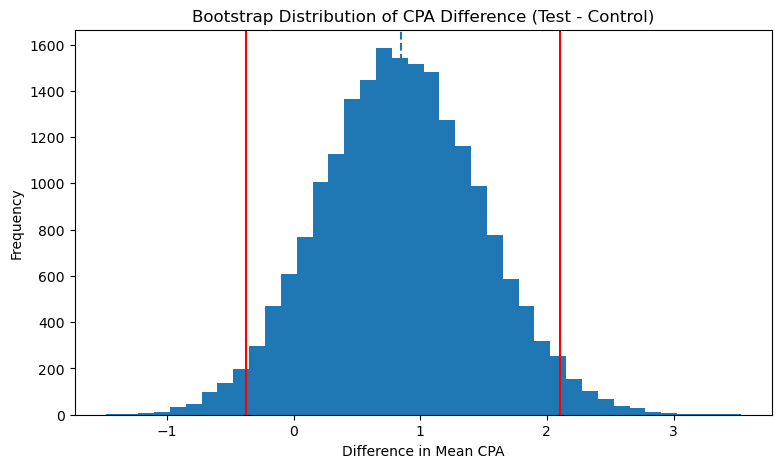

95% Bootstrap CI for CPA (Test - Control):
  2.5%:  -0.3782
  Median: 0.8392
  97.5%: 2.0998


In [5]:
control_cpa = df[df['Campaign Name'] == 'Control Campaign']['CPA'].values # список значений cpa контрольной группы
test_cpa    = df[df['Campaign Name'] == 'Test Campaign']['CPA'].values # список значений cpa тестовой группы

# функция для bootstrap доверительного интервала
def bootstrap_ci(a, b, n_boot=20000, seed=42):
    """
    a — массив контрольной группы
    b — массив тестовой группы
    возвращает 95% доверительный интервал разницы средних (b - a)
    """
    rng = np.random.default_rng(seed)
    diffs = np.empty(n_boot)

    for i in range(n_boot):
        sample_a = rng.choice(a, size=len(a), replace=True)
        sample_b = rng.choice(b, size=len(b), replace=True)
        diffs[i] = sample_b.mean() - sample_a.mean()

    return np.percentile(diffs, [2.5, 50, 97.5]), diffs

# Считаем Confidence Interval
cpa_ci, boot_diffs = bootstrap_ci(control_cpa, test_cpa)

# Строим гистограмму
plt.figure(figsize=(9, 5))
plt.hist(boot_diffs, bins=40)
plt.axvline(boot_diffs.mean(), linestyle='--')               # средняя разница
plt.axvline(np.percentile(boot_diffs, 2.5), color='red')     # 2.5%
plt.axvline(np.percentile(boot_diffs, 97.5), color='red')    # 97.5%

plt.title("Bootstrap Distribution of CPA Difference (Test - Control)")
plt.xlabel("Difference in Mean CPA")
plt.ylabel("Frequency")
plt.show()

# Вывод результата
print("95% Bootstrap CI for CPA (Test - Control):")
print(f"  2.5%:  {cpa_ci[0]:.4f}")
print(f"  Median: {cpa_ci[1]:.4f}")
print(f"  97.5%: {cpa_ci[2]:.4f}")

## Выводы из bootstrap исследования
В большей части случаев CPA тестовой группы больше CPA контрольной группы, в среднем оно больше на 0.8 доллара

## Итоги всего исследования
Принятие той или иной стратегии зависит от целей бизнеса:
- Если цель - увеличение конверсии показов рекламы в целевое действие, то стоит выбирать тестовую стратегию;
- Если цель - увеличить эффективность рекламы в рамках ROI, то лучше ничего не изменять и оставить контрольную ст